In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

Using image: datasets/dataset_Cityscapes/1024x512/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.webp


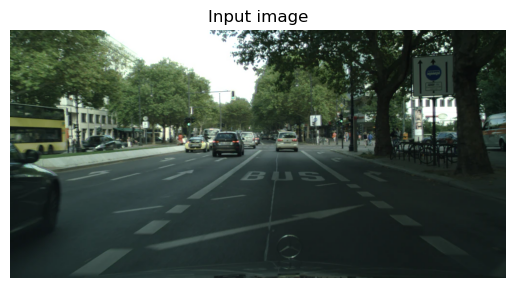

In [2]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Change this if your images live somewhere else
root = Path("datasets/dataset_Cityscapes/1024x512")

# Try webp first, then fall back to jpg/png
img_paths = sorted(root.rglob("*.webp"))
if not img_paths:
    img_paths = sorted(root.rglob("*.png"))
if not img_paths:
    img_paths = sorted(root.rglob("*.jpg"))

if not img_paths:
    raise RuntimeError("No .webp/.png/.jpg images found under datasets/dataset_Cityscapes/1024x512")

img_path = img_paths[0]
print("Using image:", img_path)

img_pil = Image.open(img_path).convert("RGB")
plt.imshow(img_pil)
plt.title("Input image")
plt.axis("off")
plt.show()


Using image: datasets/dataset_Cityscapes/1024x512/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.webp
Using device: cuda
[DeepLabV3PlusMobileNetCityscapes] Loading checkpoint from exp/0300_DeepLabV3Plus_MobileNet_Cityscapes/best_deeplabv3plus_mobilenet_cityscapes_os16.pth
[DeepLabV3PlusMobileNetCityscapes] missing keys: []
[DeepLabV3PlusMobileNetCityscapes] unexpected keys: []
Logits shape: torch.Size([1, 19, 512, 1024]) num classes: 19


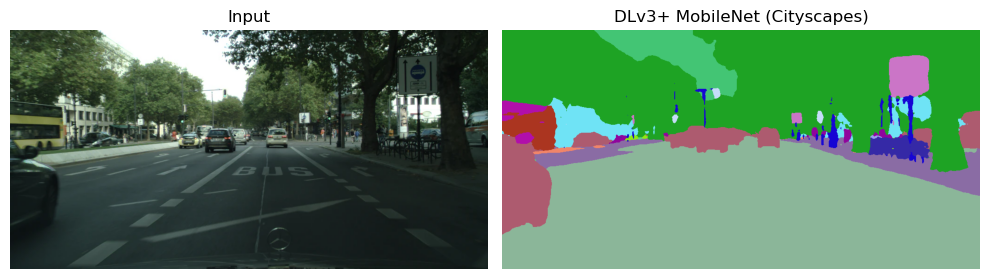

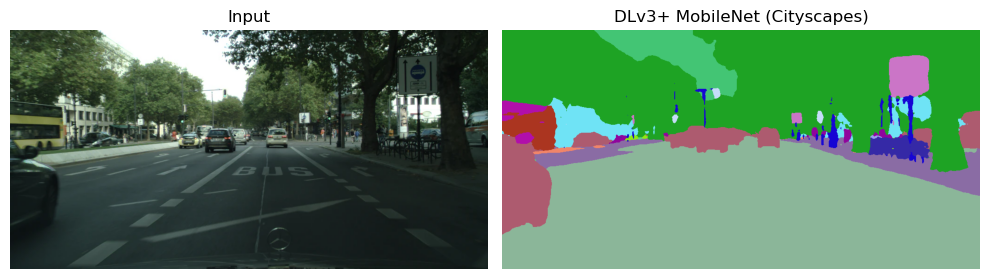

In [5]:
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.a01_sem_seg.deeplab_mobilenet_cityscapes_wrapper import DeepLabV3PlusMobileNetCityscapes

# Grab a Cityscapes image
root = Path("datasets/dataset_Cityscapes/1024x512")
img_paths = sorted(root.rglob("*.webp")) or sorted(root.rglob("*.png")) or sorted(root.rglob("*.jpg"))
img_path = img_paths[0]
print("Using image:", img_path)

img_pil = Image.open(img_path).convert("RGB")
img_np = np.array(img_pil)[:, :, ::-1].copy()  # RGB -> BGR and fix negative strides
img_b = torch.from_numpy(img_np).unsqueeze(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
seg_model = DeepLabV3PlusMobileNetCityscapes(device=device)
seg_model.eval()

with torch.no_grad():
    logits = seg_model(img_b)

pred = logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)
print("Logits shape:", logits.shape, "num classes:", int(pred.max()) + 1)

# Simple color visualization
num_classes = int(pred.max()) + 1
colors = np.random.RandomState(0).rand(num_classes, 3)
seg_color = colors[pred]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img_pil); axes[0].set_title("Input"); axes[0].axis("off")
axes[1].imshow(seg_color); axes[1].set_title("DLv3+ MobileNet (Cityscapes)"); axes[1].axis("off")
fig.tight_layout()
plt.show()
